## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_M")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,87.18412,2,25.0,0.576119,41.516993,0.611460,79.814266,8.965251,277.740071,...,368.245672,0.175542,216.250128,33.930873,496.754841,2.455708,8151.153118,2.497000,2210.0,5354.20
1,1,83.02190,1,29.0,0.104620,190.636798,0.559982,222.087675,41.537126,697.713902,...,267.444573,0.407987,227.356779,27.734884,641.982542,2.747380,-2338.896143,2.685500,1223.0,2944.30
2,0,87.32600,0,30.0,0.110000,NaN,NaN,149.860000,50.100000,NaN,...,232.310000,0.455000,214.970000,37.595000,627.575000,3.295000,NaN,2.761275,1932.0,3385.85
3,0,85.15340,0,29.0,0.227405,NaN,0.502037,236.747564,29.247323,710.169115,...,236.821140,0.502037,236.747564,29.247323,710.169115,2.923999,-1418.526557,2.956000,2180.0,3478.40
4,1,71.72600,2,22.0,0.150000,185.770000,0.550000,205.680000,31.490000,636.960000,...,272.700000,0.395000,223.495000,31.255000,621.290000,3.030000,1717.020000,2.426235,1275.0,3018.85


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((875, 22), (376, 22))

In [4]:
imputer_nonLin = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_knn = imputer_nonLin.transform(X_train)
X_test_knn = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((875, 22), (376, 22))

In [ ]:
sel = ['Age', 'MMSE', 'Hip ASM', 'Hip Variance ', 'Hip Sum Average',
       'Hip Entropy', 'ERC CONTRAST', 'ERC CORRELATION', 'ERC ENTROPY',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'TOTAL_HIPPOCAMPUS_VOLUME']

In [9]:
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Age',
 'MMSE',
 'Hip ASM',
 'Hip Variance ',
 'Hip Sum Average',
 'Hip Entropy',
 'ERC CONTRAST',
 'ERC CORRELATION',
 'ERC ENTROPY',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'TOTAL_HIPPOCAMPUS_VOLUME']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((875, 12), (376, 12))

## TPE

In [11]:
scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train_t)
X_test_t = scaler.transform(X_test_t)

In [12]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
    )
    
    C = trial.suggest_float('C', 1e-3, 100, log=True)
    tol = trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    model = LogisticRegression(C=C,
                       tol=tol,
                       class_weight="balanced",
                       solver=solver,
                       max_iter=max_iter,
                       penalty='l2',
                       random_state=42)

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [13]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-08-30 01:05:58,110] A new study created in memory with name: no-name-b97bd8b3-7073-4eb8-aeac-a9a46520cdad
[I 2025-08-30 01:05:58,393] Trial 0 finished with value: 0.7155394141462253 and parameters: {'C': 0.018622248682772655, 'tol': 0.0015058344423814938, 'solver': 'newton-cg', 'max_iter': 887}. Best is trial 0 with value: 0.7155394141462253.
[I 2025-08-30 01:05:58,536] Trial 1 finished with value: 0.7135556966826316 and parameters: {'C': 1.0359069410691932, 'tol': 0.002935062592119058, 'solver': 'sag', 'max_iter': 513}. Best is trial 0 with value: 0.7155394141462253.
[I 2025-08-30 01:05:58,640] Trial 2 finished with value: 0.7075873444294498 and parameters: {'C': 0.008583810142779801, 'tol': 0.003881157882589222, 'solver': 'sag', 'max_iter': 197}. Best is trial 0 with value: 0.7155394141462253.
[I 2025-08-30 01:05:58,894] Trial 3 finished with value: 0.7180219276194508 and parameters: {'C': 23.330170939300306, 'tol': 1.1453027143410036e-06, 'solver': 'newton-cg', 'max_iter': 2

In [14]:
study.best_params

{'C': 0.22064695385303298,
 'tol': 0.0002992946110362926,
 'solver': 'newton-cg',
 'max_iter': 718}

In [15]:
study.best_value

0.7244604094449295

In [16]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_solver,params_tol,state
0,0,0.715539,2025-08-30 01:05:58.110993,2025-08-30 01:05:58.393286,0 days 00:00:00.282293,0.018622,887,newton-cg,0.001506,COMPLETE
1,1,0.713556,2025-08-30 01:05:58.395284,2025-08-30 01:05:58.536502,0 days 00:00:00.141218,1.035907,513,sag,0.002935,COMPLETE
2,2,0.707587,2025-08-30 01:05:58.537499,2025-08-30 01:05:58.640498,0 days 00:00:00.102999,0.008584,197,sag,0.003881,COMPLETE
3,3,0.718022,2025-08-30 01:05:58.640498,2025-08-30 01:05:58.893342,0 days 00:00:00.252844,23.330171,276,newton-cg,0.000001,COMPLETE
4,4,0.717489,2025-08-30 01:05:58.894340,2025-08-30 01:05:59.069949,0 days 00:00:00.175609,0.025315,904,newton-cg,0.002985,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_19120\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


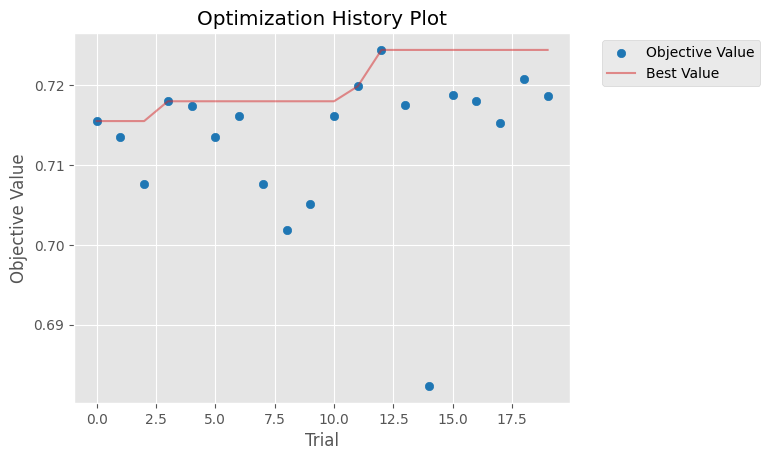

In [17]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_19120\924295173.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='C', ylabel='Objective Value'>,
       <Axes: xlabel='max_iter'>, <Axes: xlabel='solver'>,
       <Axes: xlabel='tol'>], dtype=object)

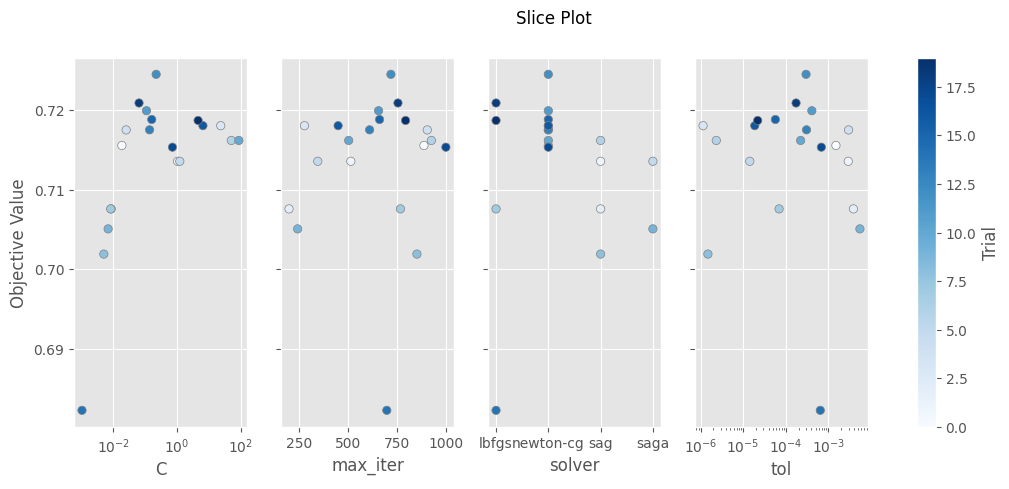

In [18]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["C", "solver", "tol", "max_iter"],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_19120\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

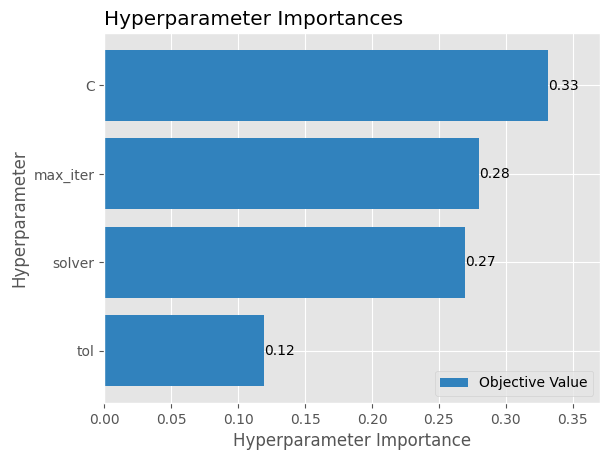

In [19]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_19120\1937692550.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

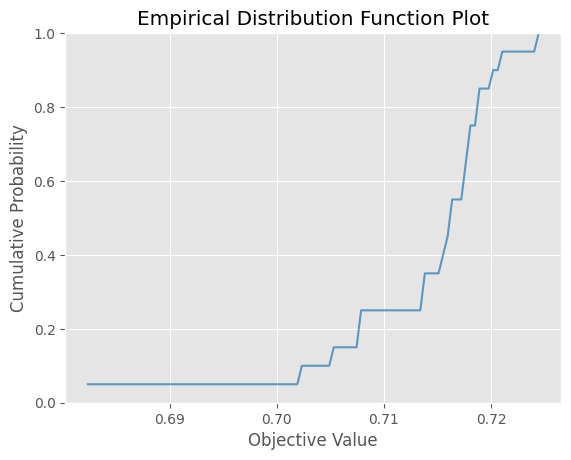

In [20]:
optuna.visualization.matplotlib.plot_edf([study])


### Classification

In [21]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)
        
        model = LogisticRegression(C=study.best_params['C'],
                       tol=study.best_params['tol'],
                       class_weight="balanced",
                       penalty='l2',
                       solver=study.best_params['solver'],
                       max_iter=study.best_params['max_iter'],
                       random_state=42)

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [22]:
trained_lg_n, metrics_lg_n = run_model("Logistic Regression", "Complete", X_train_t, y_train)

In [23]:
validation_df = pd.concat([metrics_lg_n])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

,,,,,Mean Train,Std Train,Mean Test,Std Test
Classifier,Metric,Feature Selection,Fit Time,Total Features,,,,
Logistic Regression,balanced_accuracy,Complete,0.016,12,0.734,0.005,0.724,0.052


In [24]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [25]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [26]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "None",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [27]:
results = "all"
prediction_df_report = None

if results == "all":

    pred_ngb_t = eval_model("Logistic Regression", trained_lg_n, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
prediction_df_report

Train data  \
Feature Selection Classifier          Classification Time Total Features Metric                          
None              Logistic Regression 0.082               12             accuracy                0.746   
                                                                         balanced_accuracy       0.737   
                                                                         precision_macro         0.709   
                                                                         recall_macro            0.737   
                                                                         f1_macro                0.716   
                                                                         roc_auc_macro           0.899   
                                                                         specificity_macro       0.873   

                                                                                            Test data  \
Feature Selection Classifier          Classification Time Total Features Metric                         
None              Logistic Regression 0.082               12             accuracy               0.731   
                                                                         balanced_accuracy      0.729   
                                                                         precision_macro        0.710   
                                                                         recall_macro           0.729   
                                                                         f1_macro               0.709   
                                                                         roc_auc_macro          0.899   
                                                                         specificity_macro      0.864   

                                                                                                    95% CI  \
Feature Selection Classifier          Classification Time Total Features Metric                              
None              Logistic Regression 0.082               12             accuracy           [0.686, 0.771]   
                                                                         balanced_accuracy  [0.679, 0.777]   
                                                                         precision_macro    [0.668, 0.752]   
                                                                         recall_macro       [0.679, 0.775]   
                                                                         f1_macro           [0.662, 0.755]   
                                                                         roc_auc_macro      [0.869, 0.924]   
                                                                         specificity_macro  [0.841, 0.887]   

                                                                                            Std Dev  
Feature Selection Classifier          Classification Time Total Features Metric                      
None              Logistic Regression 0.082               12             accuracy             0.023  
                                                                         balanced_accuracy    0.025  
                                                                         precision_macro      0.022  
                                                                         recall_macro         0.025  
                                                                         f1_macro             0.024  
                                                                         roc_auc_macro        0.014  
                                                                         specificity_macro    0.012

### Export model

In [28]:
trained_lg_n

LogisticRegression(C=0.22064695385303298, class_weight='balanced', max_iter=718,
                   random_state=42, solver='newton-cg',
                   tol=0.0002992946110362926)

In [29]:
import pickle

# Save the trained model using pickle
with open("logit_model.pkl", "wb") as file:
    pickle.dump(trained_lg_n, file)

print("Logistic model saved successfully!")

Logistic model saved successfully!


In [30]:
# Load the saved model using pickle
with open("logit_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)